Importing modules

In [642]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
 
series = pd.read_csv('exchange_rate.csv', index_col=0, squeeze=True)
series = pd.DataFrame(series)
series.head()

,EUR/USD Close,USD/JPY Close,USD/CHF Close,GBP/USD Close,USD/CAD Close
Date,,,,,
1/9/2017,1.05649,116.156,1.01580,1.21543,1.32276
1/10/2017,1.05582,115.743,1.01654,1.21634,1.32240
1/11/2017,1.05750,115.465,1.01498,1.22060,1.31690
1/12/2017,1.06171,114.599,1.01040,1.21621,1.31357
1/13/2017,1.06455,114.533,1.00851,1.21843,1.31225


In [681]:
eur_usd = pd.DataFrame(series['EUR/USD Close'])
usd_jpy = pd.DataFrame(series['USD/JPY Close'])
usd_chf = pd.DataFrame(series['USD/CHF Close'])
gbp_usd = pd.DataFrame(series['GBP/USD Close'])
usd_cad = pd.DataFrame(series['USD/CAD Close'])

val = usd_chf['USD/CHF Close']

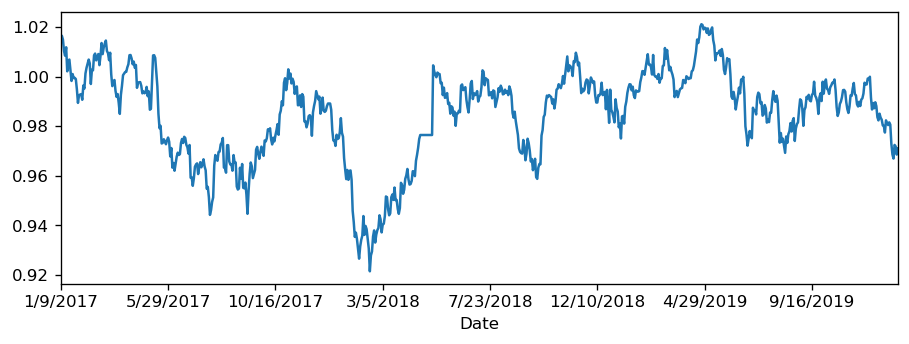

In [682]:
val.plot();

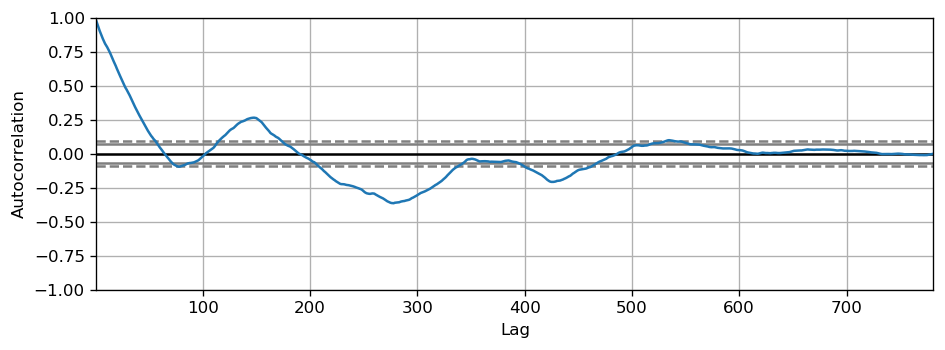

In [683]:
pd.plotting.autocorrelation_plot(val)
pyplot.show()

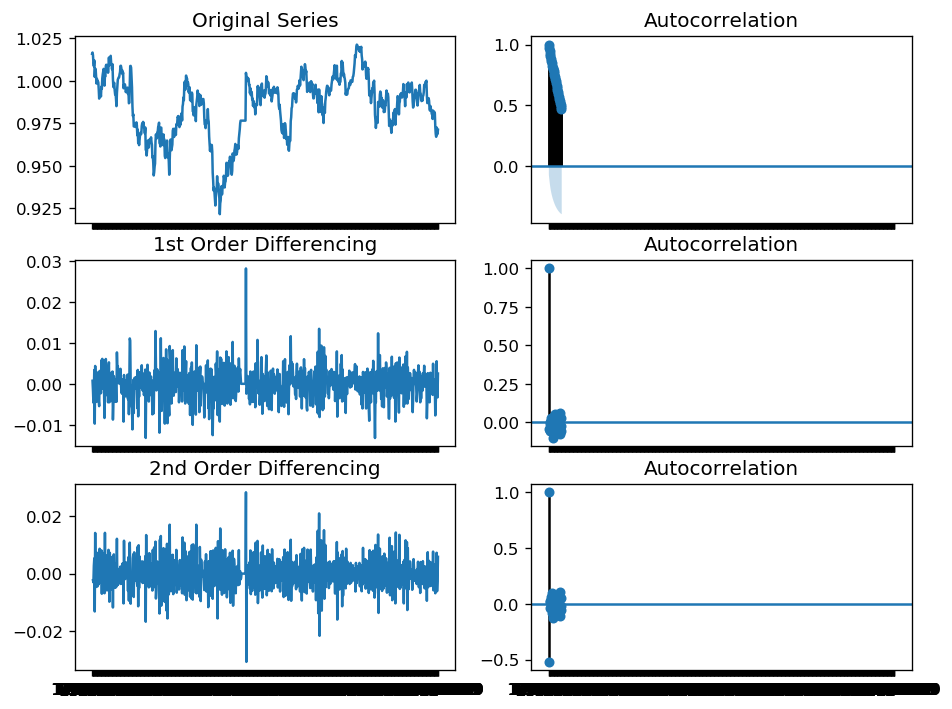

In [684]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(val); axes[0, 0].set_title('Original Series')
plot_acf(val, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(val.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(val.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(val.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(val.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [702]:
# ARIMA Model
model = ARIMA(val, order=(4,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:        D.USD/CHF Close   No. Observations:                  780
Model:                 ARIMA(4, 1, 0)   Log Likelihood                3203.012
Method:                       css-mle   S.D. of innovations              0.004
Date:                Wed, 08 Jan 2020   AIC                          -6394.024
Time:                        22:47:16   BIC                          -6366.068
Sample:                             1   HQIC                         -6383.272
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -5.72e-05      0.000     -0.447      0.655      -0.000       0.000
ar.L1.D.USD/CHF Close    -0.0431      0.036     -1.205      0.228      -0.113       0.027
ar.L2.D.

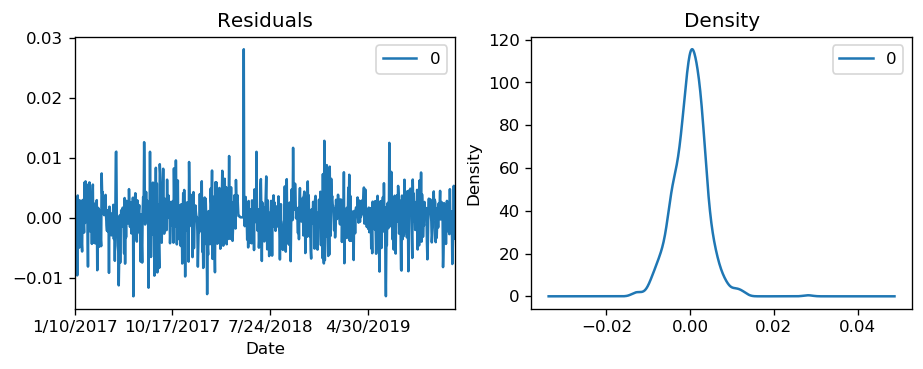

In [703]:
# Plot residual errors
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

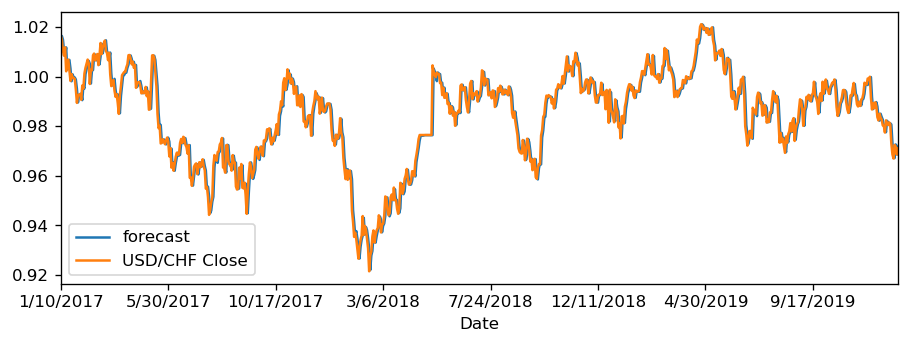

In [704]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [705]:
# Create Training and Test
train = (val[:750])
test = (val[750:])

In [706]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mse = np.mean((forecast - actual)**2)       # MSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'mse':mse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


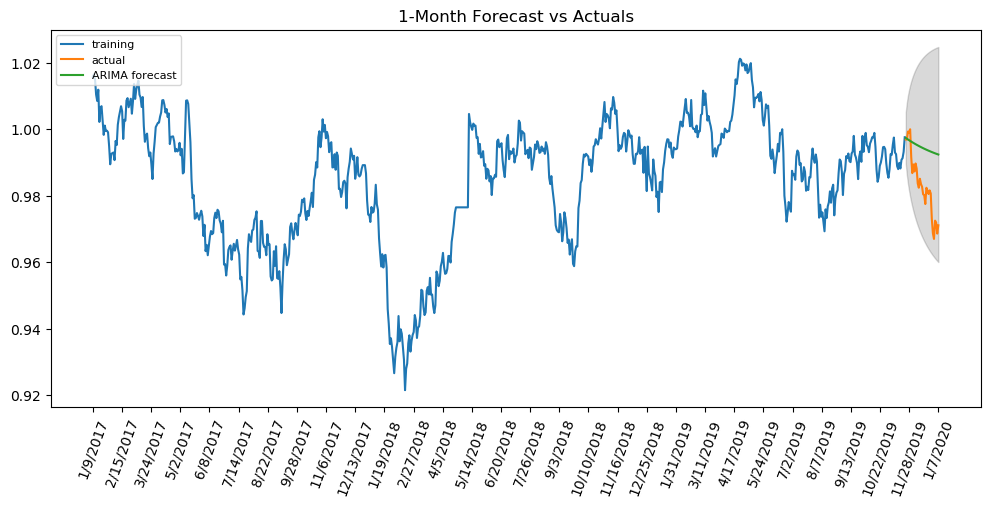

In [707]:
# Build Model
model = ARIMA(train, order=(1, 0, 0))
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(31, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='ARIMA forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('1-Month Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(ticks = None, rotation=70)
plt.xticks(np.linspace(0, 780, 30))
plt.show()

### ARIMA model accuracy

In [710]:
forecast_accuracy(fc_series, test)
# {'mape': 0.012180915657736609,
#  'me': 0.0113837402186351,
#  'mae': 0.011911231625506669,
#  'mpe': 0.011653168665991476,
#  'rmse': 0.013812008108764495,
#  'mse': 0.00019077156799657613,
#  'acf1': 0.8601390204421634,
#  'corr': 0.9438494854286019,
#  'minmax': 0.011984686220889551}

{'mape': 0.012180915657736609,
 'me': 0.0113837402186351,
 'mae': 0.011911231625506669,
 'mpe': 0.011653168665991476,
 'rmse': 0.013812008108764495,
 'mse': 0.00019077156799657613,
 'acf1': 0.8601390204421634,
 'corr': 0.9438494854286019,
 'minmax': 0.011984686220889551}

### RANDOM WALK model

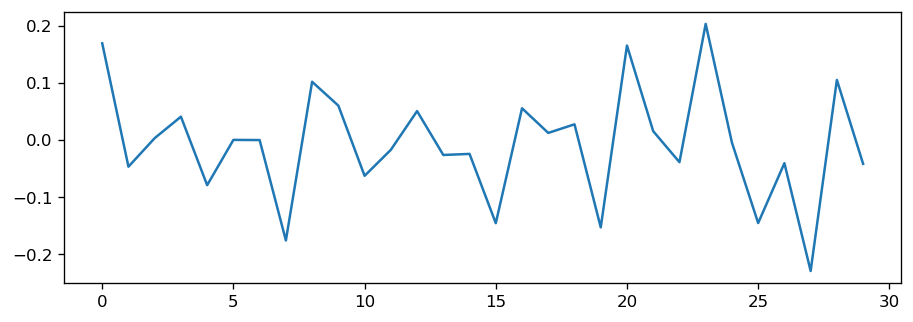

In [712]:
np.random.seed(7)
r = (np.random.randn(1, 1, 30))/10
r = r[0][0]
r = list(r)
plt.plot(r);

### Function to generate random walk series

In [713]:
def rwalk(num, rr):
    rw = [num]
    for i in rr:
        rw.append(rw[-1]+i/30)
    return list(rw)

pr = rwalk(train[-1], r);

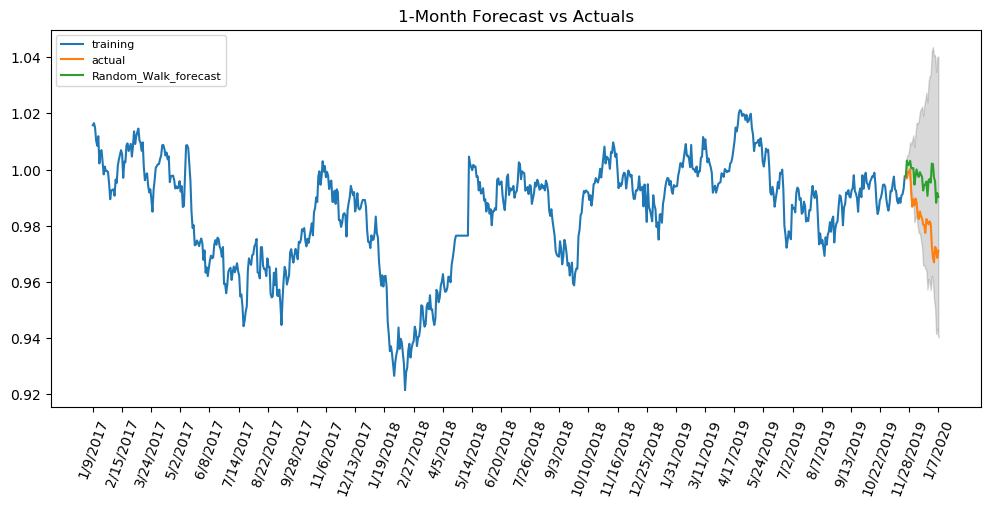

In [715]:
# # Build Model

# Make as pandas series
confed = [np.linspace(0, 0.05, 31)]

fc_series = pd.Series(pr, index=test.index)
lower_series = pd.Series(confed[0]+pr, index=test.index)
upper_series = pd.Series(-1*confed[0]+pr, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='Random_Walk_forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('1-Month Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(ticks = None, rotation=70)
plt.xticks(np.linspace(0, 780, 30))

plt.show()

### RANDOM WALK model accuracy

In [718]:
forecast_accuracy(fc_series, test)
# {'mape': 0.014359919864003588,
#  'me': 0.014052178074141154,
#  'mae': 0.014052178074141154,
#  'mpe': 0.014359919864003588,
#  'rmse': 0.01602324812541415,
#  'mse': 0.0002567444804885881,
#  'acf1': 0.8601390204421634,
#  'corr': 0.5674620984319325,
#  'minmax': 0.0140960038129605}

{'mape': 0.014359919864003588,
 'me': 0.014052178074141154,
 'mae': 0.014052178074141154,
 'mpe': 0.014359919864003588,
 'rmse': 0.01602324812541415,
 'mse': 0.0002567444804885881,
 'acf1': 0.8601390204421634,
 'corr': 0.5674620984319325,
 'minmax': 0.0140960038129605}

## 6-Month Horizon Forecast

### ARIMA MODEL

In [719]:
# Create Training and Test for 6 month horizon forecast
train = (val[:600])
test = (val[600:])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


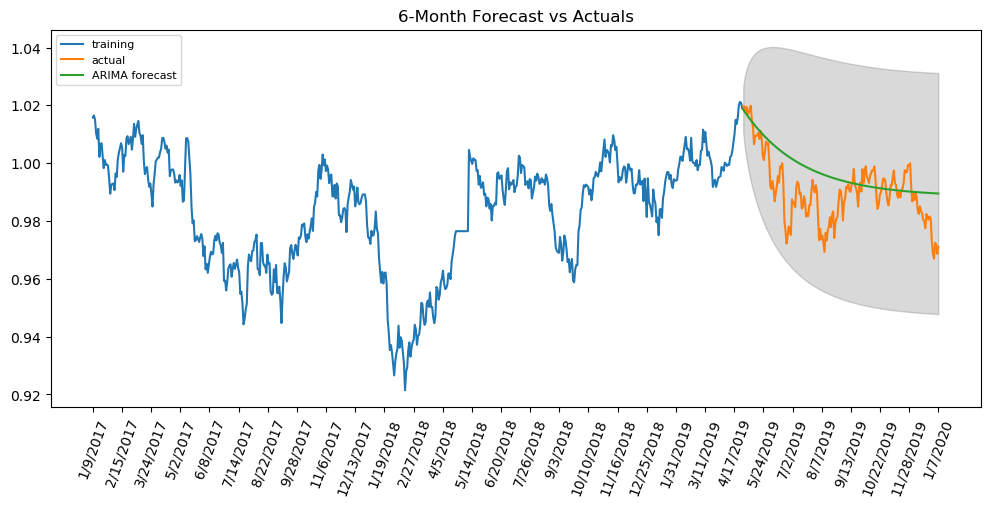

In [720]:
# Build Model
model = ARIMA(train, order=(1, 0, 0))
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(181, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='ARIMA forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('6-Month Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(ticks = None, rotation=70)
plt.xticks(np.linspace(0, 780, 30))
plt.show()

In [723]:
forecast_accuracy(fc_series, test)
# {'mape': 0.0086076587710524,
#  'me': 0.006684213813923631,
#  'mae': 0.008467333016331879,
#  'mpe': 0.006823101866863152,
#  'rmse': 0.011125729463739029,
#  'mse': 0.00012378185610031076,
#  'acf1': 0.9075317449668138,
#  'corr': 0.6164117365701247,
#  'minmax': 0.008485941653956885}

{'mape': 0.0086076587710524,
 'me': 0.006684213813923631,
 'mae': 0.008467333016331879,
 'mpe': 0.006823101866863152,
 'rmse': 0.011125729463739029,
 'mse': 0.00012378185610031076,
 'acf1': 0.9075317449668138,
 'corr': 0.6164117365701247,
 'minmax': 0.008485941653956885}

### RANDOM WALK model

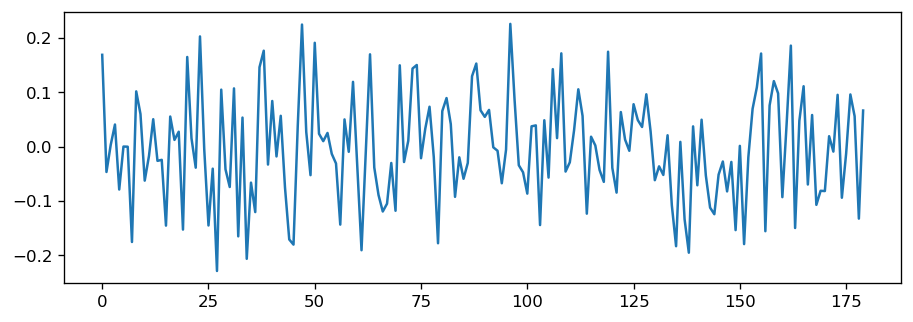

In [726]:
np.random.seed(7)
r = (np.random.randn(1, 1, 180))/10
r = r[0][0]
r = list(r)
plt.plot(r);

In [727]:
pr = rwalk(train[-1], r);

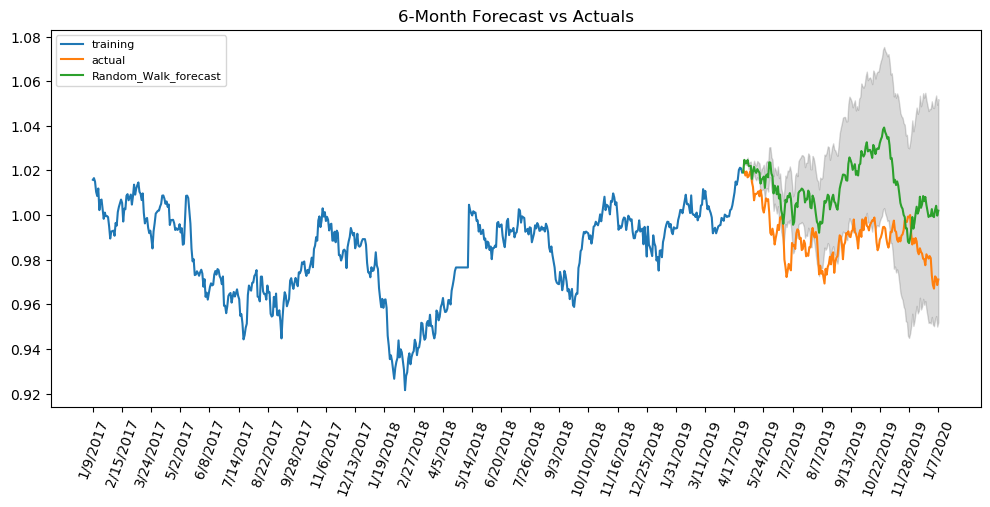

In [729]:
# # Build Model
# model = ARIMA(train, order=(11, 1, 0))
# fitted = model.fit(disp=-1)  

# # Forecast
# fc, se, conf = fitted.forecast(31, alpha=0.05)  # 95% conf

# Make as pandas series
confed = [np.linspace(0, 0.05, 181)]

fc_series = pd.Series(pr, index=test.index)
lower_series = pd.Series(confed[0]+pr, index=test.index)
upper_series = pd.Series(-1*confed[0]+pr, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='Random_Walk_forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('6-Month Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(ticks = None, rotation=70)
plt.xticks(np.linspace(0, 780, 30))

plt.show()

In [730]:
forecast_accuracy(fc_series, test)
# {'mape': 0.022713068210465447,
#  'me': 0.021989909698375148,
#  'mae': 0.022426866705031457,
#  'mpe': 0.022275848190754698,
#  'rmse': 0.025188345980560623,
#  'mse': 0.0006344527732364245,
#  'acf1': 0.9075317449668138,
#  'corr': 0.42172326439803576,
#  'minmax': 0.02208365682990987}

{'mape': 0.022713068210465447,
 'me': 0.021989909698375148,
 'mae': 0.022426866705031457,
 'mpe': 0.022275848190754698,
 'rmse': 0.025188345980560623,
 'mse': 0.0006344527732364245,
 'acf1': 0.9075317449668138,
 'corr': 0.42172326439803576,
 'minmax': 0.02208365682990987}